# MMDA Traffic Risk Pipeline Prototype

This notebook demonstrates the end-to-end workflow for predicting high-risk traffic periods in Metro Manila using the MMDA incident dataset. It is Colab-friendly and relies on the reusable pipeline implemented in `scripts/traffic_pipeline.py`. Use it to explore the data, train classification and regression models, and export artifacts for the forthcoming web application.


## Setup

If running in Google Colab:
1. Mount Google Drive or upload the repository archive.
2. Place `data_mmda_traffic_spatial.csv` under `Ahontek/data/raw/`.
3. Run the environment bootstrap cell below to install dependencies and update the Python path.


In [1]:
import sys
import subprocess
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules
REPO_ROOT = Path.cwd()

if IN_COLAB:
    # Adjust path if notebook resides inside Ahontek/notebooks in Colab runtime
    # Assumes `Ahontek` directory is in the current working directory
    if REPO_ROOT.name == "notebooks":
        REPO_ROOT = REPO_ROOT.parent
    elif REPO_ROOT.name == "Ahontek":
        pass
    else:
        # Attempt to locate `Ahontek` in common Colab setups
        potential = Path("/content/Ahontek")
        if potential.exists():
            REPO_ROOT = potential

    print(f"Running in Colab. Using repository root: {REPO_ROOT}")
else:
    print(f"Running locally. Repository root: {REPO_ROOT}")

REQUIRED_PACKAGES = [
    "pandas",
    "numpy",
    "scikit-learn",
    "joblib",
    "matplotlib",
    "seaborn",
]

for package in REQUIRED_PACKAGES:
    try:
        __import__(package.replace("-", "_"))
    except ImportError:
        print(f"Installing missing dependency: {package}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))


Running locally. Repository root: C:\Users\ivanj\Documents\Ahontek\notebooks


Installing missing dependency: scikit-learn


Installing missing dependency: seaborn


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

try:
    from scripts.traffic_pipeline import (
        PipelineConfig,
        TrafficDataLoader,
        TrafficPreprocessor,
        FeatureEngineer,
        RiskLabeler,
        run_pipeline,
    )
except ModuleNotFoundError:
    # Fallback when notebook is executed directly from the notebooks folder
    import sys

    parent_dir = Path.cwd().resolve().parent
    scripts_dir = parent_dir / "scripts"
    if scripts_dir.exists() and str(parent_dir) not in sys.path:
        sys.path.append(str(parent_dir))
    from scripts.traffic_pipeline import (
        PipelineConfig,
        TrafficDataLoader,
        TrafficPreprocessor,
        FeatureEngineer,
        RiskLabeler,
        run_pipeline,
    )

sns.set_theme(style="whitegrid")

config = PipelineConfig()
config.ensure_directories()

print(f"Using dataset: {config.raw_data_path}")


Using dataset: C:\Users\ivanj\Documents\Ahontek\data\raw\data_mmda_traffic_spatial.csv


## Data Snapshot

Preview the raw MMDA incident records and confirm column availability before running the preprocessing steps.


In [3]:
loader = TrafficDataLoader(config)
raw_df = loader.load()
raw_df.head()


2025-11-11 14:10:33,582 [INFO] Loading raw data from C:\Users\ivanj\Documents\Ahontek\data\raw\data_mmda_traffic_spatial.csv


,Date,Time,City,Location,Latitude,Longitude,High_Accuracy,Direction,Type,Lanes_Blocked,Involved,Tweet,Source
0,2018-08-20,7:55 AM,Pasig City,ORTIGAS EMERALD,14.586343,121.061481,1,EB,VEHICULAR ACCIDENT,1.0,TAXI AND MC,MMDA ALERT: Vehicular accident at Ortigas Emer...,https://twitter.com/mmda/status/10313302019705...
1,2018-08-20,8:42 AM,Mandaluyong,EDSA GUADIX,14.589432,121.057243,1,NB,STALLED L300 DUE TO MECHANICAL PROBLEM,1.0,L300,MMDA ALERT: Stalled L300 due to mechanical pro...,https://twitter.com/mmda/status/10313462477459...
2,2018-08-20,9:13 AM,Makati City,EDSA ROCKWELL,14.559818,121.040737,1,SB,VEHICULAR ACCIDENT,1.0,SUV AND L300,MMDA ALERT: Vehicular accident at EDSA Rockwel...,https://twitter.com/mmda/status/10313589669896...
3,2018-08-20,8:42 AM,Mandaluyong,EDSA GUADIX,14.589432,121.057243,1,NB,STALLED L300 DUE TO MECHANICAL PROBLEM,1.0,L300,MMDA ALERT: Stalled L300 due to mechanical pro...,https://twitter.com/mmda/status/10313590696535...
4,2018-08-20,10:27 AM,San Juan,ORTIGAS CLUB FILIPINO,14.601846,121.046754,1,EB,VEHICULAR ACCIDENT,1.0,2 CARS,MMDA ALERT: Vehicular accident at Ortigas Club...,https://twitter.com/mmda/status/10313711248424...


In [4]:
raw_summary = (
    raw_df.assign(datetime=lambda df: pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce"))
    .pipe(lambda df: df[df["datetime"].notna()])
)

print("Records:", len(raw_summary))
print("Date range:", raw_summary["datetime"].min(), "->", raw_summary["datetime"].max())
raw_summary.isna().mean().sort_values(ascending=False).head(10)


Records:

 17093
Date range: 2018-08-20 07:05:00 -> 2020-12-27 21:39:00


Direction        0.048031
Lanes_Blocked    0.034868
Involved         0.024688
City             0.010823
Type             0.003159
Location         0.001053
Longitude        0.000000
Latitude         0.000000
Date             0.000000
Time             0.000000
dtype: float64

### Incident Volume Overview

Understand temporal patterns before modelling by visualising aggregated incident counts across days and hours.


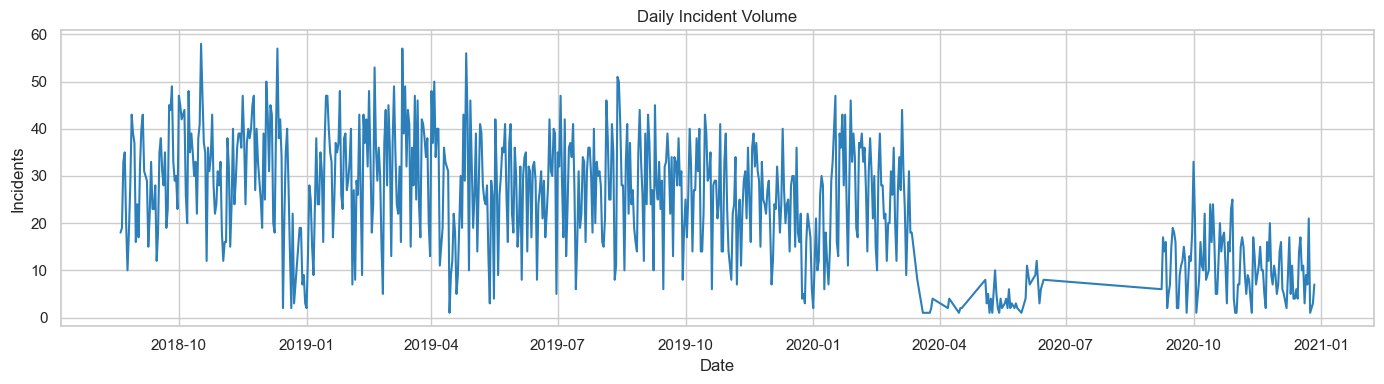

In [5]:
daily_counts = (
    raw_summary
    .assign(date=lambda df: df["datetime"].dt.date)
    .groupby("date")
    .size()
    .reset_index(name="incident_count")
)

plt.figure(figsize=(14, 4))
plt.plot(daily_counts["date"], daily_counts["incident_count"], color="#2c7fb8")
plt.title("Daily Incident Volume")
plt.xlabel("Date")
plt.ylabel("Incidents")
plt.tight_layout()
plt.show()


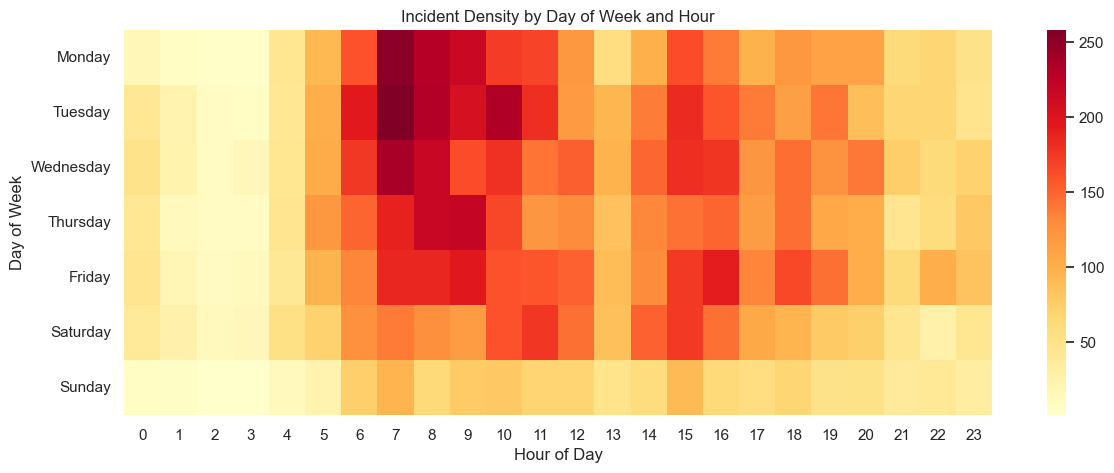

In [6]:
hourly_heatmap = (
    raw_summary
    .assign(
        hour=lambda df: df["datetime"].dt.hour,
        day_of_week=lambda df: df["datetime"].dt.day_name()
    )
    .groupby(["day_of_week", "hour"])
    .size()
    .reset_index(name="incident_count")
)

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_table = (
    hourly_heatmap
    .pivot_table(index="day_of_week", columns="hour", values="incident_count", fill_value=0)
    .reindex(day_order)
)

plt.figure(figsize=(14, 5))
sns.heatmap(heatmap_table, cmap="YlOrRd")
plt.title("Incident Density by Day of Week and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


## Pipeline Walkthrough

The following steps reuse the modular components defined in `scripts/traffic_pipeline.py` to preprocess data, engineer features, and generate classification/regression targets.


In [7]:
preprocessor = TrafficPreprocessor()
engineer = FeatureEngineer(config)
labeler = RiskLabeler(config)

processed_df = preprocessor.preprocess(raw_df)
features_df = engineer.engineer(processed_df)
labelled_df = labeler.label(features_df)

processed_df.head()


2025-11-11 14:10:34,381 [INFO] Preprocessing data...


2025-11-11 14:10:34,508 [INFO] Engineering temporal features with 1H resampling


C:\Users\ivanj\Documents\Ahontek\scripts\traffic_pipeline.py:156: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["timestamp"] = df["datetime"].dt.floor(self.config.resample_freq)


2025-11-11 14:10:34,591 [INFO] Labelling data for classification and regression tasks


,Date,Time,City,Location,Latitude,Longitude,High_Accuracy,Direction,Type,Lanes_Blocked,Involved,Tweet,Source,datetime,incident_id
17,2018-08-20,7:05 AM,QUEZON CITY,EDSA ERMIN GARCIA,14.628035,121.047229,1,SB,STALLED BUS DUE TO MECHANICAL PROBLEM,1.0,BUS,MMDA ALERT: Stalled bus due to mechanical prob...,https://twitter.com/mmda/status/10316829058046...,2018-08-20 07:05:00,2018-08-20_7:05 AM_EDSA ERMIN GARCIA_STALLED B...
0,2018-08-20,7:55 AM,PASIG CITY,ORTIGAS EMERALD,14.586343,121.061481,1,EB,VEHICULAR ACCIDENT,1.0,TAXI AND MC,MMDA ALERT: Vehicular accident at Ortigas Emer...,https://twitter.com/mmda/status/10313302019705...,2018-08-20 07:55:00,2018-08-20_7:55 AM_ORTIGAS EMERALD_VEHICULAR A...
1,2018-08-20,8:42 AM,MANDALUYONG,EDSA GUADIX,14.589432,121.057243,1,NB,STALLED L300 DUE TO MECHANICAL PROBLEM,1.0,L300,MMDA ALERT: Stalled L300 due to mechanical pro...,https://twitter.com/mmda/status/10313462477459...,2018-08-20 08:42:00,2018-08-20_8:42 AM_EDSA GUADIX_STALLED L300 DU...
2,2018-08-20,9:13 AM,MAKATI CITY,EDSA ROCKWELL,14.559818,121.040737,1,SB,VEHICULAR ACCIDENT,1.0,SUV AND L300,MMDA ALERT: Vehicular accident at EDSA Rockwel...,https://twitter.com/mmda/status/10313589669896...,2018-08-20 09:13:00,2018-08-20_9:13 AM_EDSA ROCKWELL_VEHICULAR ACC...
4,2018-08-20,10:27 AM,SAN JUAN,ORTIGAS CLUB FILIPINO,14.601846,121.046754,1,EB,VEHICULAR ACCIDENT,1.0,2 CARS,MMDA ALERT: Vehicular accident at Ortigas Club...,https://twitter.com/mmda/status/10313711248424...,2018-08-20 10:27:00,2018-08-20_10:27 AM_ORTIGAS CLUB FILIPINO_VEHI...


### High-Risk Distribution

Inspect the proportion of high-risk windows across cities to prioritise monitoring efforts.


C:\Users\ivanj\AppData\Local\Temp\ipykernel_20160\3303174101.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=risk_share, x="City", y="high_risk", palette="Reds_r")


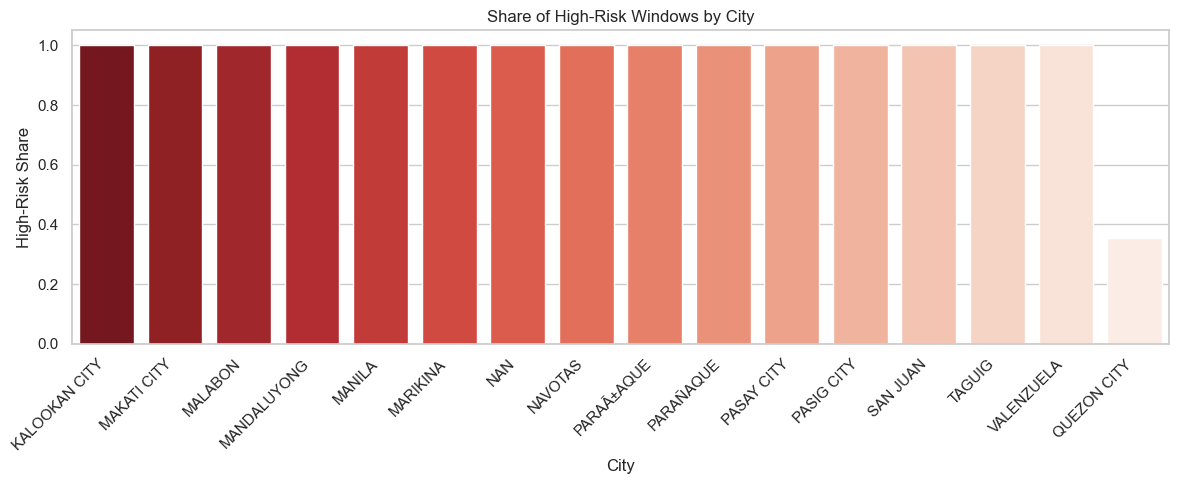

In [8]:
risk_share = (
    labelled_df.groupby("City")["high_risk"].mean().sort_values(ascending=False).reset_index()
)

plt.figure(figsize=(12, 5))
sns.barplot(data=risk_share, x="City", y="high_risk", palette="Reds_r")
plt.title("Share of High-Risk Windows by City")
plt.xlabel("City")
plt.ylabel("High-Risk Share")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [9]:
features_df.head()


,timestamp,City,incidents,lanes_blocked,unique_types,hour,day_of_week,is_weekend,is_holiday,incidents_lag_1h,incidents_lag_3h,incidents_lag_6h,incidents_lag_24h
0,2018-08-20 07:00:00,PASIG CITY,1,1.0,1,7,0,0,0,0.0,0.0,0.0,0.0
1,2018-08-20 07:00:00,QUEZON CITY,1,1.0,1,7,0,0,0,0.0,0.0,0.0,0.0
2,2018-08-20 08:00:00,MANDALUYONG,1,1.0,1,8,0,0,0,0.0,0.0,0.0,0.0
3,2018-08-20 09:00:00,MAKATI CITY,1,1.0,1,9,0,0,0,0.0,0.0,0.0,0.0
4,2018-08-20 10:00:00,SAN JUAN,1,1.0,1,10,0,0,0,0.0,0.0,0.0,0.0


In [10]:
labelled_df["high_risk"].value_counts(normalize=True)


high_risk
1    0.719717
0    0.280283
Name: proportion, dtype: float64

## Train Models

Run the automated pipeline (only if evaluation artifacts are missing) to produce classification and regression models alongside saved diagnostics.


In [11]:
import json

reports_dir = config.artifacts_dir / "reports"
metrics_path = reports_dir / "evaluation_metrics.json"
required_reports = [
    metrics_path,
    reports_dir / "classification_eval.csv",
    reports_dir / "regression_eval.csv",
]
missing_reports = [path for path in required_reports if not path.exists()]

if missing_reports:
    print("Missing evaluation artifacts detected; running pipeline to regenerate...")
    evaluation_metrics = run_pipeline(config)
else:
    with open(metrics_path, "r", encoding="utf-8") as fh:
        evaluation_metrics = json.load(fh)

if metrics_path.exists() and missing_reports:
    with open(metrics_path, "r", encoding="utf-8") as fh:
        evaluation_metrics = json.load(fh)


### Evaluation Summary

Load persisted reports from `artifacts/reports/` to review model quality and prepare diagnostics mirroring the project’s detailed reporting style.


In [12]:
metrics_table = (
    pd.DataFrame(evaluation_metrics)
    .T.reset_index()
    .rename(columns={"index": "task"})
)
metrics_table


,task,roc_auc_mean,roc_auc_std,average_precision_mean,accuracy_mean,precision_mean,recall_mean,f1_mean,confusion_matrix,mae_mean,mae_std,rmse_mean,rmse_std,r2_mean
0,classification,1.0,0.0,1.0,1.0,1.0,1.0,1.0,"{'0': {'0': 2992, '1': 0}, '1': {'0': 0, '1': ...",NaN,NaN,NaN,NaN,NaN
1,regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000015,0.000004,0.000138,0.000201,1.0


In [13]:
classification_metrics = metrics_table.loc[metrics_table["task"] == "classification"]
if "confusion_matrix" in classification_metrics.columns:
    display(classification_metrics.drop(columns=["confusion_matrix"]))
else:
    display(classification_metrics)


,task,roc_auc_mean,roc_auc_std,average_precision_mean,accuracy_mean,precision_mean,recall_mean,f1_mean,mae_mean,mae_std,rmse_mean,rmse_std,r2_mean
0,classification,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN


In [14]:
classification_eval_path = config.artifacts_dir / "reports" / "classification_eval.csv"
classification_eval = pd.read_csv(classification_eval_path, parse_dates=["timestamp"])
classification_eval.head()


,timestamp,City,incidents,fold,actual_high_risk,pred_high_risk,pred_high_risk_proba
0,2018-12-10 20:00:00,QUEZON CITY,2,1,1,1,0.999989
1,2018-12-10 21:00:00,MANDALUYONG,1,1,1,1,0.999989
2,2018-12-10 21:00:00,QUEZON CITY,2,1,1,1,0.999989
3,2018-12-10 22:00:00,QUEZON CITY,1,1,0,0,0.000032
4,2018-12-10 22:00:00,TAGUIG,1,1,1,1,0.999989


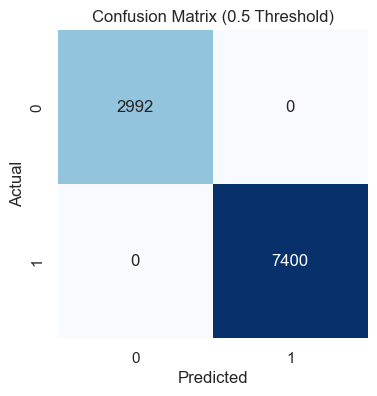

In [15]:
cm = confusion_matrix(
    classification_eval["actual_high_risk"],
    (classification_eval["pred_high_risk_proba"] >= 0.5).astype(int)
)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (0.5 Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


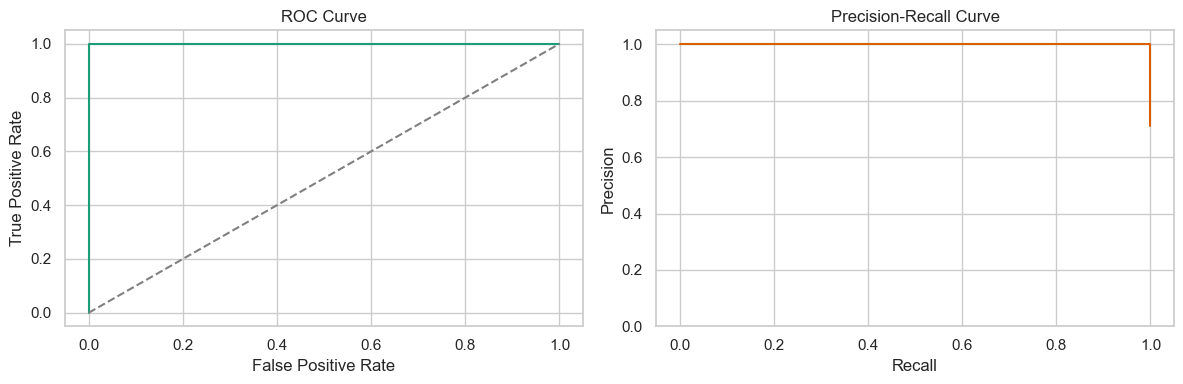

In [16]:
fpr, tpr, _ = roc_curve(
    classification_eval["actual_high_risk"],
    classification_eval["pred_high_risk_proba"],
)
precision, recall, _ = precision_recall_curve(
    classification_eval["actual_high_risk"],
    classification_eval["pred_high_risk_proba"],
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(fpr, tpr, color="#1b9e77")
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].set_title("ROC Curve")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

axes[1].plot(recall, precision, color="#d95f02")
axes[1].set_title("Precision-Recall Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()


In [17]:
cls_importance_path = config.artifacts_dir / "reports" / "classification_feature_importance.csv"
if cls_importance_path.exists():
    cls_importance = pd.read_csv(cls_importance_path).head(15)
    cls_importance


In [18]:
regression_eval_path = config.artifacts_dir / "reports" / "regression_eval.csv"
regression_eval = pd.read_csv(regression_eval_path, parse_dates=["timestamp"])
regression_eval.head()


,timestamp,City,incidents,fold,actual_incidents,pred_incidents
0,2018-12-10 20:00:00,QUEZON CITY,2,1,2,1.999984
1,2018-12-10 21:00:00,MANDALUYONG,1,1,1,1.000009
2,2018-12-10 21:00:00,QUEZON CITY,2,1,2,1.999984
3,2018-12-10 22:00:00,QUEZON CITY,1,1,1,1.000009
4,2018-12-10 22:00:00,TAGUIG,1,1,1,1.000009


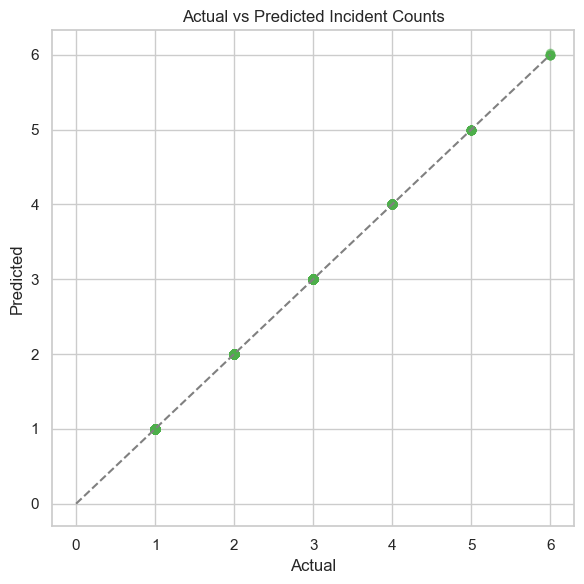

In [19]:
plt.figure(figsize=(6, 6))
plt.scatter(
    regression_eval["actual_incidents"],
    regression_eval["pred_incidents"],
    alpha=0.5,
    color="#4daf4a",
)
plt.plot([0, regression_eval["actual_incidents"].max()], [0, regression_eval["actual_incidents"].max()], linestyle="--", color="gray")
plt.title("Actual vs Predicted Incident Counts")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()


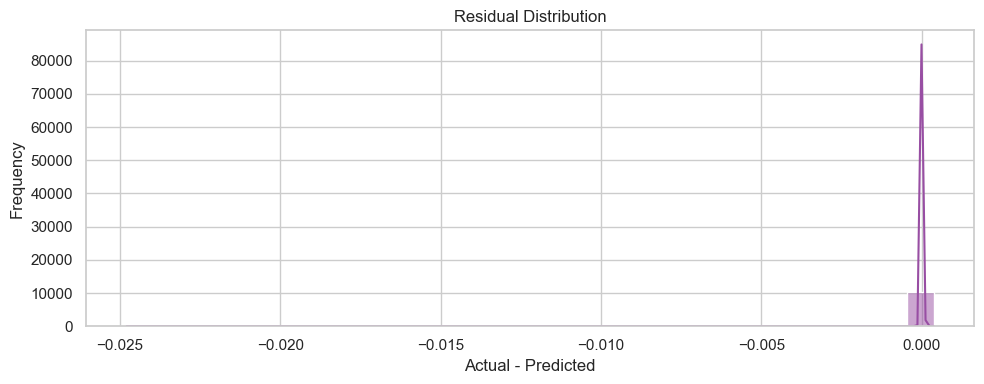

In [20]:
regression_eval = regression_eval.assign(residual=lambda df: df["actual_incidents"] - df["pred_incidents"])

plt.figure(figsize=(10, 4))
sns.histplot(regression_eval["residual"], bins=30, kde=True, color="#984ea3")
plt.title("Residual Distribution")
plt.xlabel("Actual - Predicted")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [21]:
reg_importance_path = config.artifacts_dir / "reports" / "regression_feature_importance.csv"
if reg_importance_path.exists():
    reg_importance = pd.read_csv(reg_importance_path).head(15)
    reg_importance


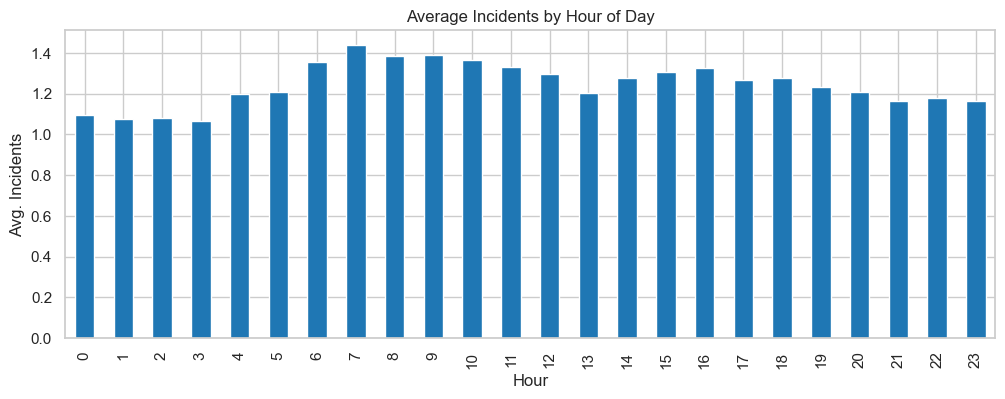

In [22]:
plt.figure(figsize=(12, 4))
plot_data = labelled_df.groupby(labelled_df["timestamp"].dt.hour)["incidents"].mean()
plot_data.plot(kind="bar", color="#1f77b4")
plt.title("Average Incidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Avg. Incidents")
plt.show()


### Pipeline Outputs

Preview the aggregated outputs and high-risk windows generated by the latest pipeline run.


In [23]:
evaluation_metrics


{'classification': {'roc_auc_mean': 1.0,
  'roc_auc_std': 0.0,
  'average_precision_mean': 1.0,
  'accuracy_mean': 1.0,
  'precision_mean': 1.0,
  'recall_mean': 1.0,
  'f1_mean': 1.0,
  'confusion_matrix': {'0': {'0': 2992, '1': 0}, '1': {'0': 0, '1': 7400}}},
 'regression': {'mae_mean': 1.4784552191785093e-05,
  'mae_std': 4.486591455760064e-06,
  'rmse_mean': 0.00013832428313227915,
  'rmse_std': 0.00020120961304239716,
  'r2_mean': 0.9999998564581397}}

In [24]:
outputs_path = config.artifacts_dir / "outputs" / "incident_windows.csv"
outputs_df = pd.read_csv(outputs_path, parse_dates=["timestamp"])
outputs_df.head()


,timestamp,City,incidents,lanes_blocked,unique_types,hour,day_of_week,is_weekend,is_holiday,incidents_lag_1h,incidents_lag_3h,incidents_lag_6h,incidents_lag_24h,high_risk,target_incidents
0,2018-08-20 07:00:00,PASIG CITY,1,1.0,1,7,0,0,0,0.0,0.0,0.0,0.0,1,1
1,2018-08-20 07:00:00,QUEZON CITY,1,1.0,1,7,0,0,0,0.0,0.0,0.0,0.0,0,1
2,2018-08-20 08:00:00,MANDALUYONG,1,1.0,1,8,0,0,0,0.0,0.0,0.0,0.0,1,1
3,2018-08-20 09:00:00,MAKATI CITY,1,1.0,1,9,0,0,0,0.0,0.0,0.0,0.0,1,1
4,2018-08-20 10:00:00,SAN JUAN,1,1.0,1,10,0,0,0,0.0,0.0,0.0,0.0,1,1


In [25]:
high_risk_windows = (
    outputs_df[outputs_df["high_risk"] == 1]
    .assign(hour=lambda df: df["timestamp"].dt.hour)
    .groupby(["City", "hour"], as_index=False)
    .size()
    .sort_values("size", ascending=False)
)
high_risk_windows.head(10)


,City,hour,size
60,MANDALUYONG,15,197
215,QUEZON CITY,7,194
217,QUEZON CITY,9,172
216,QUEZON CITY,8,168
59,MANDALUYONG,14,167
61,MANDALUYONG,16,166
53,MANDALUYONG,8,166
52,MANDALUYONG,7,166
218,QUEZON CITY,10,161
54,MANDALUYONG,9,157


## Next Steps

- Adjust `PipelineConfig` parameters (e.g., `resample_freq`, lag windows, model choices) to experiment with different horizons.
- Publish model artifacts (`traffic_classifier.joblib`, `traffic_regressor.joblib`) to the web app backend for inference.
- Extend feature engineering with external data sources such as weather, road works, or public events.
- Validate predictions against held-out recent weeks before deploying to production.
